# Clustering Crypto

In [1]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [2]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [3]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.

In [4]:
# Alternatively, use the provided csv file:
crypto_df = pd.read_csv("crypto_data.csv", index_col=0)
crypto_df.shape


(1252, 6)

### Data Preprocessing

In [5]:
# Keep only necessary columns:

# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'


In [6]:
crypto_df

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...
XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


In [7]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df['IsTrading']]
crypto_df.head(5)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [8]:
# Keep only cryptocurrencies with a working algorithm
##All seem to have an algorithm

In [9]:
# Remove the "IsTrading" column
crypto_df.drop(columns=['IsTrading'], inplace=True)
crypto_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [10]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna()

In [11]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df['TotalCoinsMined']!=0]

In [12]:
# Drop rows where there are 'N/A' text values
crypto_df = crypto_df[(crypto_df['CoinName']!= "N/A") & (crypto_df['Algorithm']!="N/A") & (crypto_df['ProofType']!="N/A")]

In [13]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coins_name_df = pd.DataFrame(crypto_df.CoinName)
coins_name_df

,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum
...,...
ZEPH,ZEPHYR
GAP,Gapcoin
BDX,Beldex
ZEN,Horizen


In [14]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df.drop(columns=['CoinName'], inplace=True)

In [15]:
# Create dummy variables for text features
X = pd.get_dummies(crypto_df,columns=['Algorithm', 'ProofType'])

In [16]:
# Standardize data
crypto_scaled = StandardScaler().fit_transform(X)

### Reducing Dimensions Using PCA

In [17]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(crypto_scaled)

In [21]:
# Create a DataFrame with the principal components data
pcs_df = pd.DataFrame(
    data=crypto_pca, columns=["PC 1", "PC 2", "PC 3"]
)
pcs_df.head()

,PC 1,PC 2,PC 3
0,-0.326145,1.048280,-0.560504
1,-0.309390,1.047697,-0.561071
2,2.324872,1.363950,-0.687529
3,-0.153082,-1.336140,0.167125
4,-0.161258,-1.961954,0.340172


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

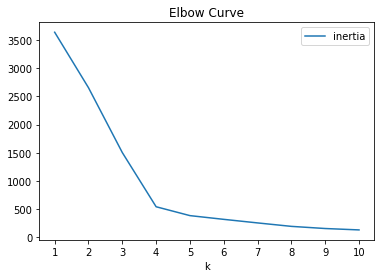

In [22]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

Running K-Means with `k=<your best value for k here>`

In [26]:
# Initialize the K-Means model
km = KMeans(n_clusters=4, random_state=0)
# Fit the model
km.fit(pcs_df)
# Predict clusters
predictions = km.predict(pcs_df)
# Creating a new DataFrame including predicted clusters and cryptocurrencies features
pcs_df['class'] = km.labels_
pcs_df.index = crypto_df.index


In [27]:
crypto_df.head()
clustered_df = pd.concat([crypto_df, pcs_df, coins_name_df], axis=1, )
clustered_df.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,class,CoinName
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.326145,1.048280,-0.560504,0,42 Coin
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.309390,1.047697,-0.561071,0,404Coin
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.324872,1.363950,-0.687529,0,EliteCoin
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.153082,-1.336140,0.167125,1,Bitcoin
ETH,Ethash,PoW,1.076842e+08,0,-0.161258,-1.961954,0.340172,1,Ethereum


### Visualizing Results

#### 3D-Scatter with Clusters

In [28]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(clustered_df, x="PC 1", y="PC 2", z="PC 3", color="class", hover_name="CoinName", hover_data=["Algorithm"])
fig.show()

#### Table of Tradable Cryptocurrencies

In [36]:
# Table with tradable cryptos
coins_name_df

,CoinName
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum
...,...
ZEPH,ZEPHYR
GAP,Gapcoin
BDX,Beldex
ZEN,Horizen


In [34]:
# Print the total number of tradable cryptocurrencies
print(f' There are {clustered_df["CoinName"].count()} tradable cryptocurrencies')

 There are 533 tradable cryptocurrencies


#### Scatter Plot with Tradable Cryptocurrencies

In [38]:
# Scale data to create the scatter plot

clustered_df['TotalCoinSupply'] = clustered_df['TotalCoinSupply'].astype("float")
scaled_two = clustered_df[['TotalCoinSupply', 'TotalCoinsMined']]
scaled_two = StandardScaler().fit_transform(scaled_two)
scaled_two = pd.DataFrame(scaled_two, columns=['TotalCoinSupply', 'TotalCoinsMined'])

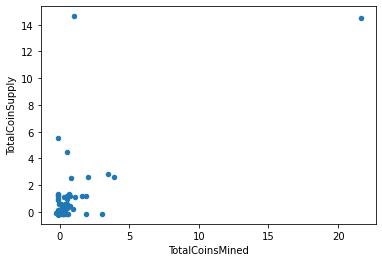

In [39]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
scaled_two.plot.scatter(x="TotalCoinsMined", y="TotalCoinSupply")